In [1]:
import os
import sys


module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
if "notebooks" in os.getcwd():
    os.chdir("..")
    # %cd ".."

In [7]:
from datasets import load_dataset
from omegaconf import OmegaConf
from transformers import AutoTokenizer

import train
from src.utils import instantiate

In [8]:
model_id = "NousResearch/Meta-Llama-3-8B"
data_config = "./data/swisstext2023/llama3.yaml"

In [11]:
tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    padding_side="left",
    # add_eos_token=True,
    # add_bos_token=True,
)

tokenizer.pad_token = tokenizer.eos_token

data_config = OmegaConf.load(data_config)
collator = instantiate(data_config.collator, tokenizer=tokenizer)

dataset = load_dataset(
    data_config.dataset.type,
    data_files={"train": data_config.dataset.train, "eval": data_config.dataset.eval},
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Generating train split: 41092 examples [00:01, 41035.66 examples/s]
Generating eval split: 5136 examples [00:00, 42041.76 examples/s]


In [12]:
formatting_func = train.formatting_func(
    data_config.prompt, tokenizer.eos_token if data_config.append_eos_token else None
)


def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))


tokenized_train_dataset = dataset["train"].map(generate_and_tokenize_prompt, batched=True, batch_size=8)
tokenized_val_dataset = dataset["eval"].map(generate_and_tokenize_prompt, batched=True, batch_size=8)

Map:   0%|          | 0/41092 [00:00<?, ? examples/s]

Map: 100%|██████████| 5136/5136 [00:04<00:00, 1260.01 examples/s]


46228


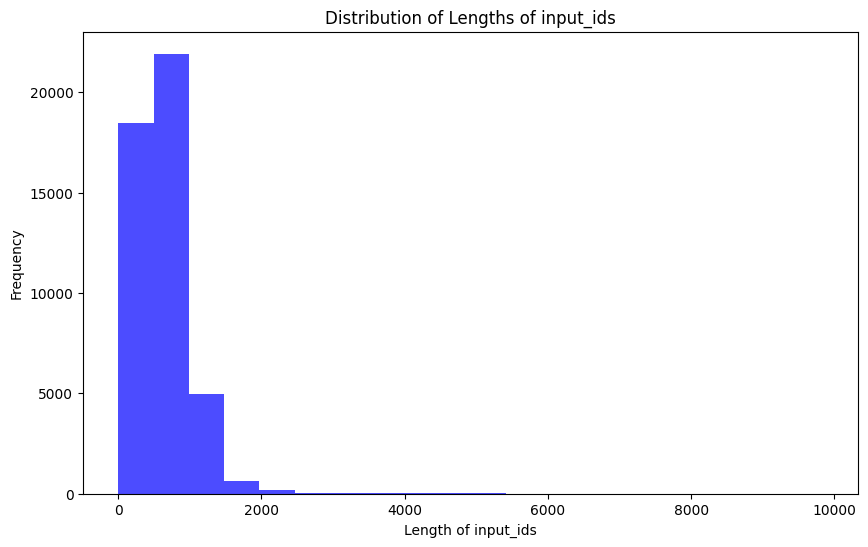

In [13]:
import matplotlib.pyplot as plt


def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x["input_ids"]) for x in tokenized_train_dataset]
    lengths += [len(x["input_ids"]) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color="blue")
    plt.xlabel("Length of input_ids")
    plt.ylabel("Frequency")
    plt.title("Distribution of Lengths of input_ids")
    plt.show()


plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)